In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy import interpolate
import csv
import datetime
from scipy.optimize import curve_fit
from numpy import arange
from matplotlib import pyplot
import seaborn as sns

In [17]:
#parameter values - constants
m = 5/3
mod_start = 90
tstep = 5
krea = 0.00025
beta = 1.55
delt = 30
L = 4660
W = 316

In [18]:
#metabolism model inputs # transient storage two station method
metab_inputs = pd.read_csv('twost_solute_model_inputs.csv')
metab_inputs.set_index(['t'],inplace=True)
metab_inputs['date_time'] =  pd.to_datetime(metab_inputs['date_time'], format='%d/%m/%Y %H:%M')
metab_inputs['us'] = 0.0047 * (metab_inputs['Q'] ** 0.8699)
metab_inputs['uadz'] = (1 + beta) * metab_inputs['us'] 
metab_inputs['cadz'] = m * metab_inputs['uadz']
metab_inputs['Tflowadz_emp'] = (L / metab_inputs['cadz']) / 60 #unit:min
metab_inputs['Tsadz'] = (L / metab_inputs['us']) / 60 #unit:min
metab_inputs['Tuadz'] = (L / metab_inputs['uadz']) / 60 #unit:min
metab_inputs['dep'] = (metab_inputs['Q'] * (metab_inputs['Tflowadz_emp']*60)) / (W * L)
metab_inputs.set_index(['reach'],inplace=True)

In [19]:
#dcdt function
def calc_nep(t, delt, tstep, mod_start, Ci, Cobs, krea, Cs, dep, Tsadz, Tuadz): 

    tf = mod_start + t
    deltx = int(delt/tstep)
    
    tau_s = Tsadz[tf] - Tuadz[tf]
    Tadz = Tuadz[tf]
    t_lag = round(tf - int(tau_s/tstep))    

    nep = (
        ((Cobs[tf+deltx] - Cobs[tf]) / delt) - 
        ((Ci[t_lag] - Cobs[tf]) * (Qi[t_lag] / (Q[tf] * Tadz))) -
        (krea * (Cs[tf] - Cobs[tf]))
        ) * dep[tf] * 1000

    return nep

In [20]:
timesteps = len(metab_inputs) - int(delt/tstep)

NEPmodel = np.full((timesteps), np.nan)


for time_step in range(timesteps - mod_start):

    Qi = metab_inputs['Qi'].tolist()
    Q = metab_inputs['Q'].tolist()
    Ci = metab_inputs['Ci'].tolist()
    PAR = metab_inputs['PAR'].tolist()
    Cs = metab_inputs['Cs'].tolist()
    dep = metab_inputs['dep'].tolist()
    Cobs= metab_inputs['Cobs'].tolist()
    Tsadz = metab_inputs['Tsadz'].tolist()
    Tflowadz_emp = metab_inputs['Tflowadz_emp'].tolist() 
    Tuadz = metab_inputs['Tuadz'].tolist()
    
    #print(time_step)
    NEPmodel[time_step + mod_start] = calc_nep(t=time_step, delt=delt, tstep=tstep, mod_start=mod_start, Ci=Ci, Cobs=Cobs, krea=krea, Cs=Cs, dep=dep, Tsadz=Tsadz, Tuadz=Tuadz)

    

In [21]:
deltx = int(delt/tstep)
NEPmodel = np.append(NEPmodel, np.repeat(np.nan, deltx))
NEPmodel
metab_inputs['NEP'] = NEPmodel[:]

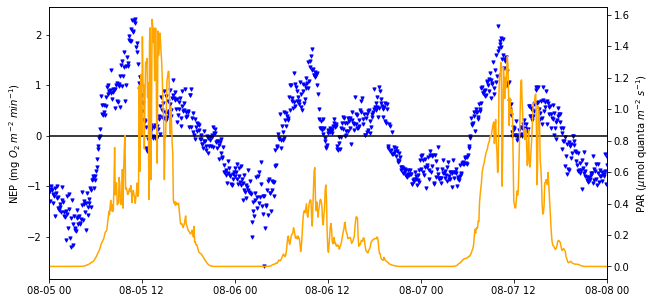

In [22]:
#plot NEP
fig, ax = plt.subplots(1,figsize=(10,5))
ax2 = ax.twinx()
ax.scatter('date_time', 'NEP',data=metab_inputs,color='blue', marker="v", s=10)
ax2.plot('date_time','PAR',data=metab_inputs,color = 'orange')
ax.set_xlim([datetime.date(2019, 8, 5), datetime.date(2019, 8, 8)])
ax.axhline(y=0, color='black', linestyle='-')
ax.set_ylabel('NEP (mg $O_2$ $m^{-2}$ $min^{-1}$)')
ax2.set_ylabel('PAR ($\mu$mol quanta $m^{-2}$ $s^{-1}$)')

plt.savefig('nep_twost.png')

In [23]:
metab_inputs['NEP_gday'] = metab_inputs['NEP'] / 1000 *60 * 24
metab_inputs['light_metab'] = np.where(metab_inputs['PAR_umol']>1,metab_inputs['NEP_gday'],999) 
metab_inputs['dark_metab'] = np.where(metab_inputs['PAR_umol']<1,metab_inputs['NEP_gday'],0)
metab_inputs = metab_inputs.reset_index()
metab_inputs = metab_inputs.set_index('date_time')
df_avg = metab_inputs.resample('D').mean()
df_avg = df_avg.loc['2019-08-05':'2019-08-07']

In [24]:
metab_filt = metab_inputs.loc['2019-08-05':'2019-08-07']
metab_filt['er_daily'] = np.nan

for date in df_avg.index.strftime('%Y-%m-%d'):
        date_ids = metab_filt.index[metab_filt.index.strftime('%Y-%m-%d') == date]
        metab_filt['er_daily'][date_ids] = df_avg['dark_metab'][date]
        

metab_filt['gpp_daily'] = np.where(metab_filt['light_metab'] == 999.0, 0, metab_filt['light_metab']-metab_filt['er_daily'])
metab_filt.head(3)
metab_filt.to_csv('two_st_out_adz.csv')

C:\Users\devpat\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\devpat\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\devpat\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\series.py:1098: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

y = 1.80904 * x / 160.29471 + x


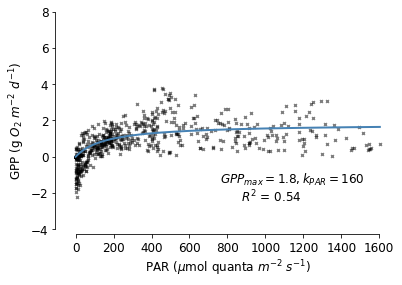

In [25]:
#non linear curve fit
par = metab_filt['PAR_umol'].values
gpp_daily = metab_filt['gpp_daily'].values

def objective(x, a, b):
    return (a * x) / (b + x)


x, y = par, gpp_daily
popt, pcov = curve_fit(objective, x, y)
a, b = popt
print('y = %.5f * x / %.5f + x' % (a, b))

residuals = y- objective(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)

r_squared = 1 - (ss_res / ss_tot)

# plot input vs output
pyplot.scatter(x, y,marker='x',alpha=0.5, s = 8,c='k') 
x_line = arange(min(x), max(x), 1)
y_line = objective(x_line, a, b)
pyplot.plot(x_line, y_line, '-',linewidth=2, color='steelblue')
plt.xlabel('PAR ($\mu$mol quanta $m^{-2}$ $s^{-1}$)',size=12)
plt.ylabel('GPP (g $O_2$ $m^{-2}$ $d^{-1}$)',size=12)


string = r'$GPP_{{max}} = %.1f, k_{{PAR}} = %.0f$'% (a, b)
plt.text(760,-1.5,string,size=12)
plt.text(870,-2.5,'$R^2$ = %.2f' % r_squared,size=12)
plt.yticks(np.arange(-4,10,2))
plt.tick_params(axis='both', labelsize=12)
sns.despine(offset=5, trim=True)
plt.savefig('gpp_par_twost.png',bbox_inches='tight',dpi=500)